# 1. Setup

In [1]:
from matplotlib_scalebar.scalebar import ScaleBar
from pqdm.processes import pqdm

from utils import *

# 2. Prepare data

## 2.1. Jobs (LEHD)

State codes downloaded from [here](https://www.bls.gov/respondents/mwr/electronic-data-interchange/appendix-d-usps-state-abbreviations-and-fips-codes.htm).

In [2]:
state_list = (pd.read_csv('../data/zones/state_codes.csv')
              .sort_values('fips').head(50)).disp()

50 rows x 3 cols; Memory: 0.0 MiB


name      code     fips
   <object>  <object>  <int64>
0   Alabama        AL        1

In [3]:
def get_lehd_jobs(table, year=2021, state_list=state_list, overwrite=False):
    outpath = Path(f'../data/lehd/{table}_{year}.parquet')
    if outpath.exists() and not overwrite:
        return pd.read_parquet(outpath)
    assert table in ['rac', 'wac'], table
    root = 'https://lehd.ces.census.gov/data/lodes/LODES8'
    segments = D(S000='total', SE01='low_earn', SE03='high_earn')
    dfs = []
    for _, r in tqdm(state_list.iterrows(), total=len(state_list)):
        try:
            state = r['code'].lower()
            for seg_key, seg_name in segments.items():
                url = (f'{root}/{state}/{table}/'
                       f'{state}_{table}_{seg_key}_JT00_{year}.csv.gz')
                df = pd.read_csv(url)
                df['geoid'] = df.iloc[:, 0].astype(str).str.zfill(15).str[:12]
                df = df.groupby('geoid')['C000'].sum().rename('jobs').reset_index()
                dfs.append(df.assign(segment=seg_name))
        except Exception as e:
            print(f'ERROR: {r["name"]}, segment={seg_name} :{e}')
    df = pd.concat(dfs).pivot_table('jobs', 'geoid', 'segment', sort=False)
    df = df.fillna(0).astype(np.int32).reset_index().rename_axis(None, axis=1)
    df.to_parquet(mkfile(outpath))
    return df
    
rac = get_lehd_jobs('rac', overwrite=0).disp() # t=4:08
wac = get_lehd_jobs('wac', overwrite=0).disp(0) # t=1:57 (error in AK, AR, MS)

238,182 rows x 4 cols; Memory: 18.4 MiB


geoid    total low_earn high_earn
       <object>  <int32>  <int32>   <int32>
0  010010201001      234       52       106

232,125 rows x 4 cols; Memory: 26.9 MiB


geoid    total low_earn high_earn
  <category>  <int32>  <int32>   <int32>

## 2.1. POIs (SafeGraph)

### 2.1.1. POI categories
Each SafeGraph POI category was manually classified by trip purpose and essentiality.

In [4]:
with open('../data/pois/poi_categories.yml', 'r') as f:
    cats = yaml.safe_load(f)['SafeGraph']
cats = Pdf(sum([[D(purpose=k, top_category=x) for x in v] 
                for k, v in cats.items()], []))
cats = cats.query('purpose != "Overall"').disp()

20 rows x 2 cols; Memory: 0.0 MiB


purpose             top_category
    <object>                 <object>
90  Services  Child Day Care Services

### 2.1.2. Count POIs by purpose & BG

In [5]:
def get_sg_poi_count(categories=cats, year=2020, overwrite=False):
    outpath = Path(f'../data/pois/sg_count_{year}.parquet')
    if outpath.exists() and not overwrite:
        return pd.read_parquet(outpath)
    poi_path = '/home/umni2/a/umnilab/data/safegraph/pois/us/2020-11-06.parquet'
    zone_path = f'../data/zones/us/bg_{year}.parquet'
    poi = pd.read_parquet(poi_path, columns=['top_category', 'lon', 'lat'])
    poi = poi.merge(categories, 'left', on='top_category')
    poi = pdf2gdf(poi, 'lon', 'lat', CRS_DEG)
    bg = gpd.read_parquet(zone_path, columns=['geoid', 'geometry'])
    poi = poi.sjoin(bg, predicate='within')
    poi = pd.concat([
        poi.groupby(['purpose', 'geoid']).size().reset_index(),
        poi.groupby('geoid').size().reset_index().assign(purpose='Overall')
    ]).reset_index(drop=1).rename(columns={0: 'n_pois', 'geoid': 'cbg'})
    poi.to_parquet(mkfile(outpath))
    return poi

tot_poi = get_sg_poi_count(overwrite=0).disp() # t=0:44

681,065 rows x 3 cols; Memory: 91.8 MiB


purpose           cbg   n_pois
   <object>      <object>  <int64>
0   Leisure  010010201001        2

In [6]:
tot_poi.groupby('purpose')['n_pois'].sum().to_frame().T

purpose  Leisure  Overall  Services  Shopping
n_pois   1040318  5551806    559395    290096

### Combine jobs & POIs

In [7]:
opport = pd.concat([
    wac.melt('geoid', var_name='kind', value_name='opport').assign(is_work=True),
    (tot_poi.rename(columns=D(cbg='geoid', purpose='kind', n_pois='opport'))
     .assign(is_work=False).assign(kind=lambda df: df.kind.str.lower()))
]).astype(D(opport=np.int32)).disp()

1,377,440 rows x 4 cols; Memory: 192.3 MiB


geoid      kind   opport is_work
       <object>  <object>  <int32>  <bool>
0  010010201001     total      124    True

## 2.2. Compute accessibility

### 2.2.1. Impedance function

In [8]:
df = pd.read_csv('../data/nhts/fitted-params-power-exponential.csv')
df = df.query('mode != "Transit" & measure == "Duration" & parameter != "r2"')
df = df.pivot_table('value', ['mode', 'purpose'], 'parameter').reset_index()
df['mode'] = df['mode'].str.lower()
df['purpose'] = (df['purpose'].str.lower()
                 .str.replace('social/recreational', 'leisure')
                 .str.replace('other', 'services'))
imped_params = df.rename_axis(None, axis=1).disp(None)

15 rows x 4 cols; Memory: 0.0 MiB


mode   purpose      alpha       beta
    <object>  <object>  <float64>  <float64>
0       bike  services   0.039438   1.023212
1       bike   overall   0.025748   1.202151
2       bike  shopping   0.012158   1.519313
3       bike   leisure   0.036398   1.099888
4       bike      work   0.007254   1.603613
5      drive  services   0.018876   1.359185
6      drive   overall   0.018096    1.32847
7      drive  shopping   0.015053   1.469516
8      drive   leisure   0.021972   1.230737
9      drive      work   0.007628     1.4668
10      walk  services   0.030111   1.085209
11      walk   overall   0.052866   1.010898
12      walk  shopping   0.021661   1.401153
13      walk   leisure   0.082771   0.947031
14      walk      work   0.055893    1.07912

### 2.2.2. Potential accessibility
This only requires total jobs at the destination, not the OD flows

In [9]:
# travel time thresholds (in minutes)
thresholds = (15, 30, 45, 60, 90)

In [10]:
def get_access(level, region, mode, thresh, year=2020,
               opport=opport, params=imped_params,
               save=False, overwrite=False):
    outpath = Path(f'../data/access/{level}/{region}_{mode}_{thresh}.parquet')
    if outpath.exists() and not overwrite:
        if save: return
        else: return pd.read_parquet(outpath)
    cat_cols = 'region mode thresh purpose kind geoid'.split()
    try:
        opport = opport.groupby(['kind', 'is_work', 'geoid']).sum().reset_index()
        tt_file = f'../data/osrm/{level}/{region}/bg_{mode}_{year}.parquet'
        tt_cols = D(src_geoid='src', trg_geoid='trg', duration='time')
        tt = pd.read_parquet(tt_file, columns=tt_cols.keys()).rename(columns=tt_cols)
        tt = tt.set_index(['src', 'trg'])['time'] / 60 # travel time in minutes
        t = tt[tt <= thresh] # travel times for filtered OD pairs
        dfs = []
        for (is_work, kind), df in opport.groupby(['is_work', 'kind']):
            coef = params.query(f'mode=="{mode}"').set_index('purpose')
            row = coef.loc['work' if is_work else kind]
            od = np.exp(-row.alpha * t ** row.beta).rename('weight').reset_index()
            od = od.merge(df, left_on='trg', right_on='geoid')
            od['access'] = od['opport'] * od['weight']
            xs = od.groupby(['src', 'kind'])['access'].sum().reset_index()
            xs = xs.rename(columns=D(src='geoid'))
            xs = xs.assign(kind=kind, purpose='work' if is_work else 'nonwork')
            dfs.append(xs)
        xs = pd.concat(dfs).assign(region=region, mode=mode, thresh=str(thresh))
        xs = xs.astype(D(access=np.float32) | {x: CAT for x in cat_cols})
        xs = xs[cat_cols + ['access']]
    except Exception as e:
        # raise ValueError(e)
        xs = Pdf([], columns=cat_cols + ['access'])
    if save:
        xs.to_parquet(mkfile(outpath))
        return
    return xs

# x = get_access('state', 'arkansas', 'drive', 30, overwrite=0).disp()
x = get_access('msa', 'chicago', 'drive', 30, overwrite=0).disp()
# x = get_access('msa', 'austin', 'drive', 30, overwrite=0).disp()

47,061 rows x 7 cols; Memory: 1.5 MiB


region        mode      thresh     purpose        kind         geoid  \
   <category>  <category>  <category>  <category>  <category>    <category>   
0     chicago       drive          30     nonwork     leisure  170310101001   

        access  
     <float32>  
0  5233.838867

In [11]:
def get_access_all(level, year=2020, njobs=16, overwrite=False):
    outpath = Path(f'../data/access/{level}_{year}.parquet')
    if outpath.exists() and not overwrite:
        return pd.read_parquet(outpath)
    files = sorted(glob(f'../data/osrm/{level}/*/bg_*_2020.parquet'))
    cases = sum([[D(level=level, region=f.split('/')[-2], thresh=t, year=2020,
                    mode=f.split('/')[-1].split('_')[1], save=1, overwrite=1)
                  for t in thresholds] for f in files], [])
    np.random.shuffle(cases) # shuffle to hopefully reduce parallel load
    print(len(cases))
    pqdm(cases, get_access, n_jobs=njobs, argument_type='kwargs')
    xs = []
    for f in tqdm(list(Path(f'../data/access/{level}').glob('*'))):
        rgn, mode, thresh = f.stem.split('_')
        df = pd.read_parquet(f).assign(region=rgn, mode=mode, thresh=thresh)
        xs.append(df)
    cat_cols = 'region purpose kind mode thresh geoid'.split()
    xs = pd.concat(xs).reset_index(drop=1).astype(
        {x: CAT for x in cat_cols})[cat_cols + ['access']]
    xs.to_parquet(mkfile(outpath))
    return xs
    
xs_msa = get_access_all('msa', overwrite=0).disp() # t=14:36
xs_st = get_access_all('state', overwrite=0).disp() # t=11:07

12,956,475 rows x 7 cols; Memory: 172.8 MiB


region     purpose        kind        mode      thresh         geoid  \
   <category>  <category>  <category>  <category>  <category>    <category>   
0      austin     nonwork     leisure       drive          30  480219501011   

      access  
   <float32>  
0  43.496025

8,238,700 rows x 7 cols; Memory: 125.8 MiB


region     purpose        kind        mode      thresh         geoid  \
   <category>  <category>  <category>  <category>  <category>    <category>   
0     arizona     nonwork     leisure       drive          15  040019426001   

      access  
   <float32>  
0        0.0

# 3. Analyze

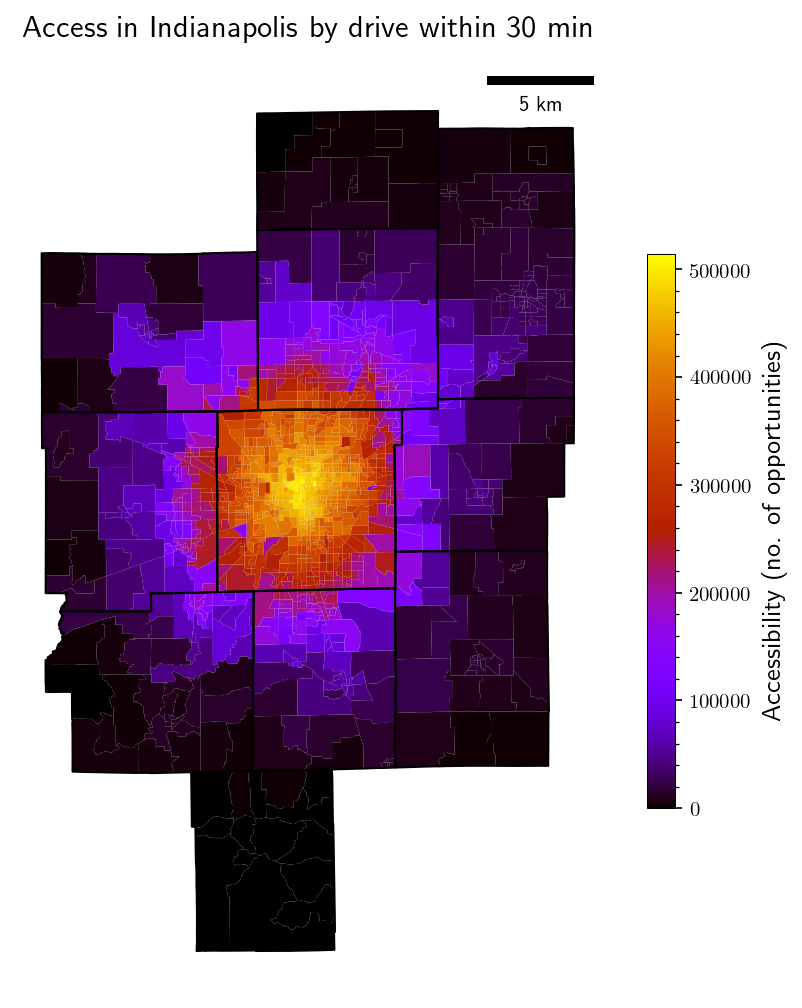

In [12]:
def plot_access_map(level, region, kind, mode, thresh,
                    vmin=0, vmax=None, size=(8, 8), dpi=150, cmap='gnuplot'):
    xs = get_access(level, region, mode, thresh, overwrite=0)
    if kind == 'low2high':
        low = xs[xs.kind == 'low_earn'].set_index('geoid')['access'].rename('low')
        high = xs[xs.kind == 'high_earn'].set_index('geoid')['access'].rename('high')
        xs = (low / high).rename('access').reset_index()
    else:
        xs = xs[xs.kind == kind][['geoid', 'access']].reset_index(drop=1)
    bgs = gpd.read_parquet(f'../data/zones/{level}_2020.parquet', filters=[
        ('scale', '==', 'bg'), ('region', '==', region)])
    cnty = gpd.read_parquet(f'../data/zones/{level}_2020.parquet', filters=[
        ('scale', '==', 'county'), ('region', '==', region)])
    xs = bgs[['geoid', 'geometry']].merge(xs, on='geoid')
    ax = pplot(size=size, dpi=dpi, axoff=1, 
               title='Access in {} by {} within {} min'.format(
                   region.title().replace('-', ' '), mode, thresh))
    label = ('Accessibility (no. of opportunities)' if kind != 'low2high' 
             else 'Ratio of access to low-earnings\nto high-earnings jobs')
    xs.to_crs(CRS_M).plot(
        ax=ax, column='access', vmin=vmin, vmax=vmax, legend=True,
        cmap='RdYlGn_r' if kind == 'low2high' else cmap, 
        legend_kwds=D(shrink=0.6, label=label))
    cnty.to_crs(CRS_M).plot(ax=ax, fc='none', ec='k', lw=1)
    ax.add_artist(ScaleBar(0.2))
    return

# x = plot_access_map('msa', 'chicago', 'total', 'drive', '60'); x
x = plot_access_map('msa', 'indianapolis', 'total', 'drive', '30'); x

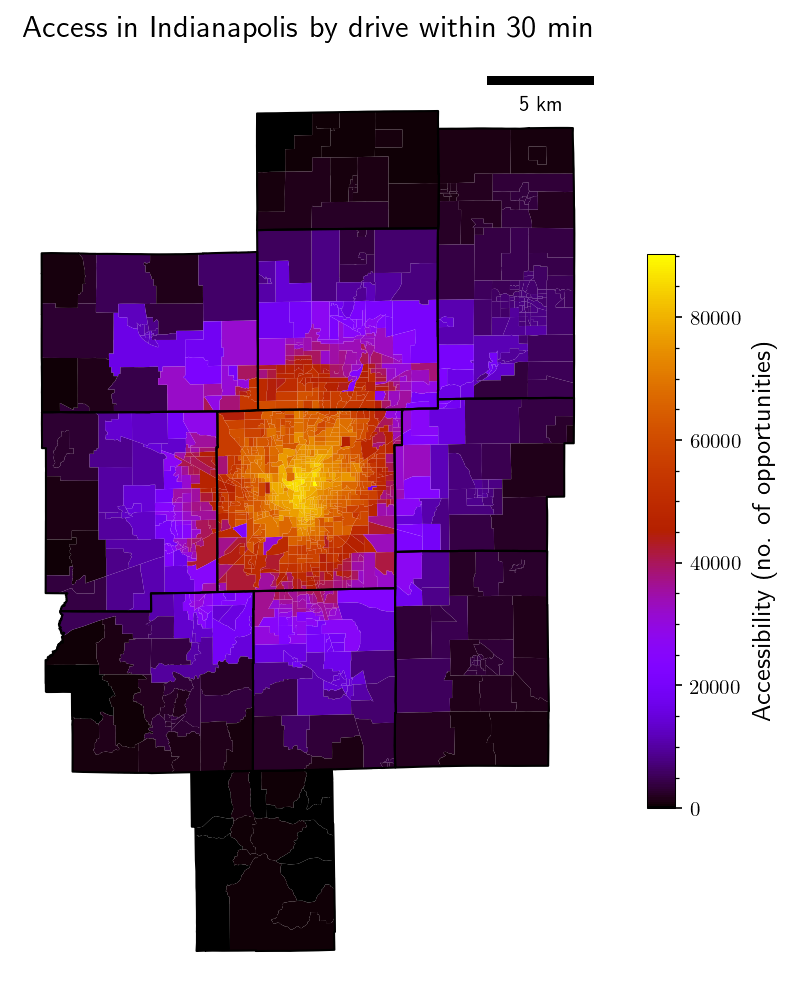

In [13]:
plot_access_map('msa', 'indianapolis', 'low_earn', 'drive', '30')

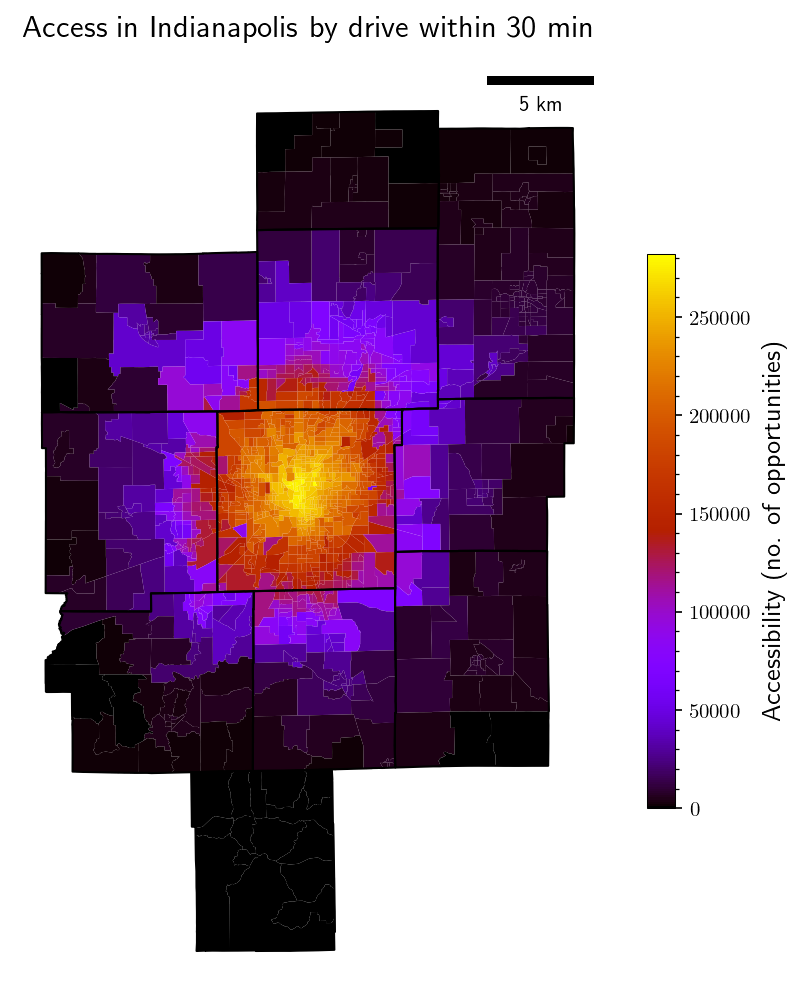

In [14]:
plot_access_map('msa', 'indianapolis', 'high_earn', 'drive', '30')

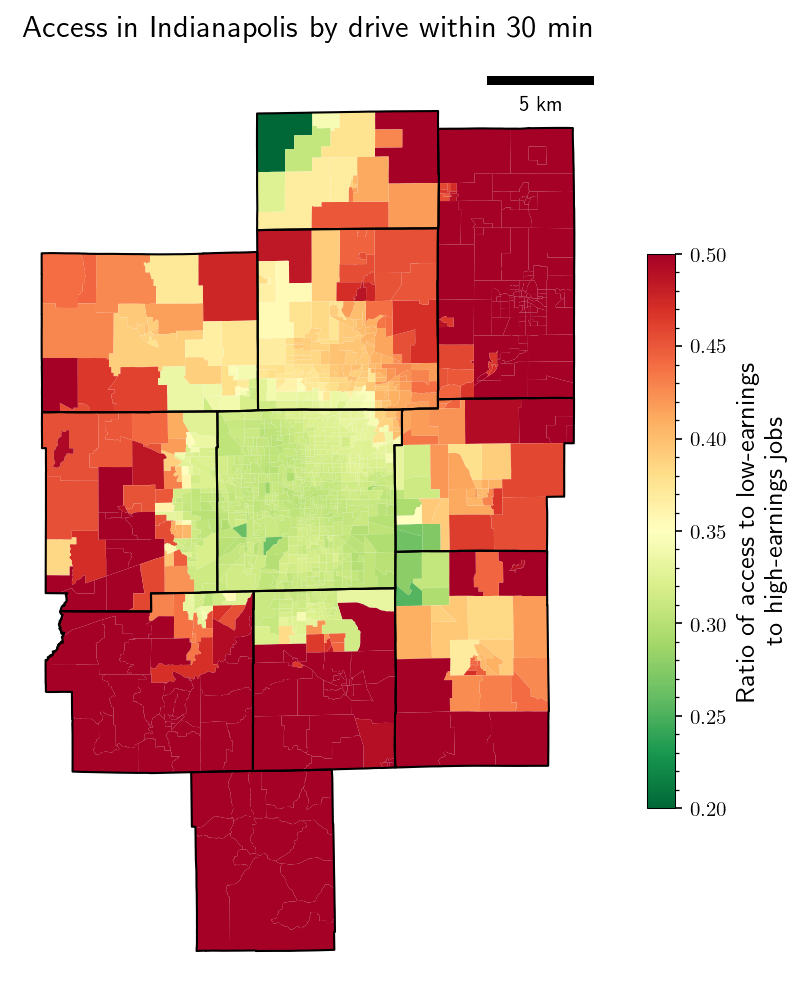

In [15]:
plot_access_map('msa', 'indianapolis', 'low2high', 'drive', '30', vmin=0.2, vmax=0.5)

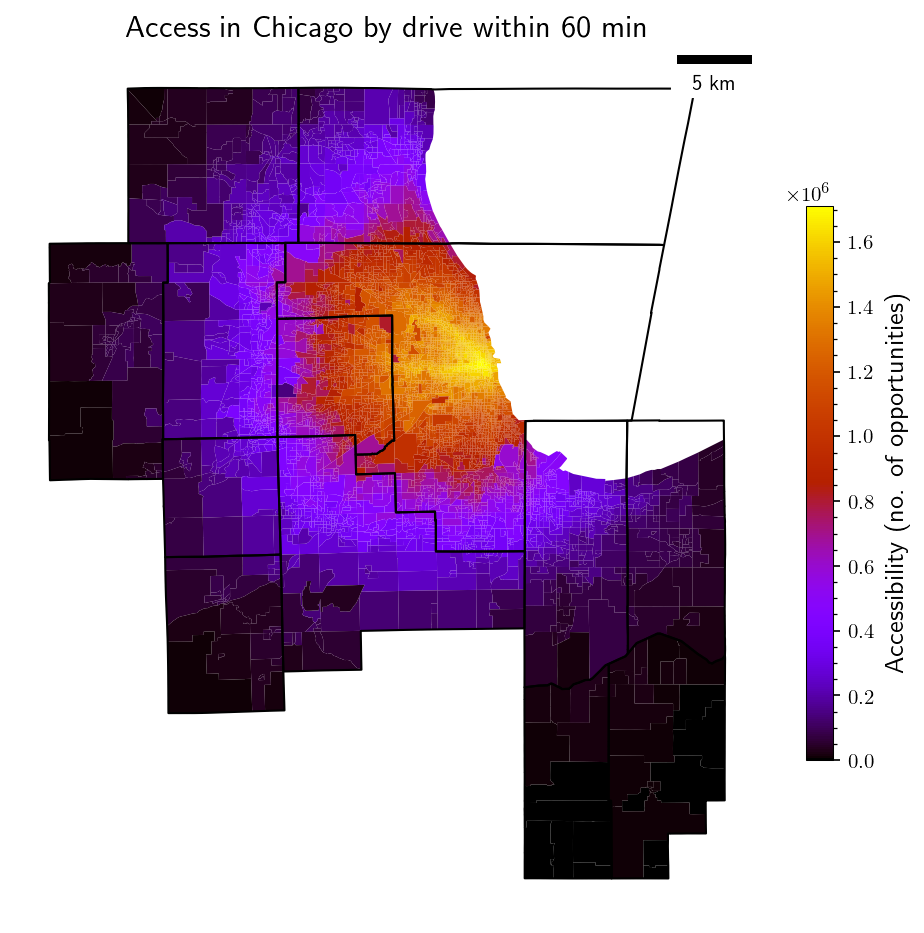

In [16]:
plot_access_map('msa', 'chicago', 'total', 'drive', '60')

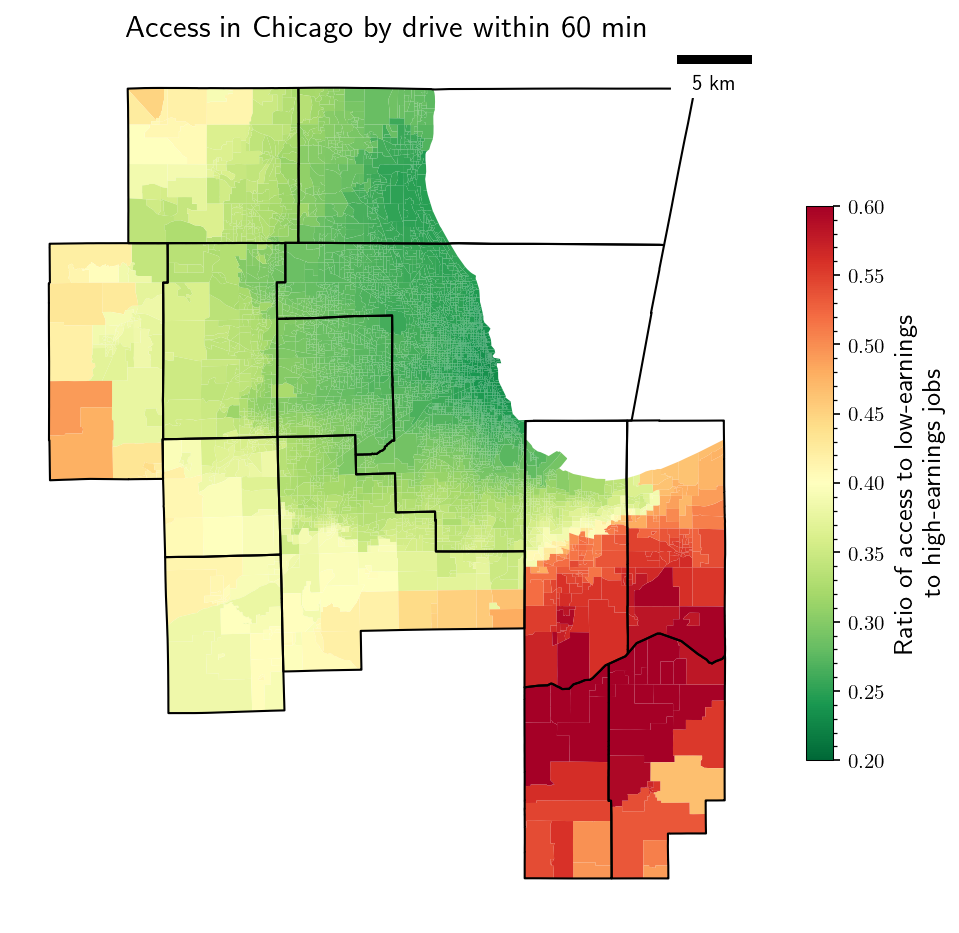

In [17]:
plot_access_map('msa', 'chicago', 'low2high', 'drive', '60', vmin=0.2, vmax=0.6)

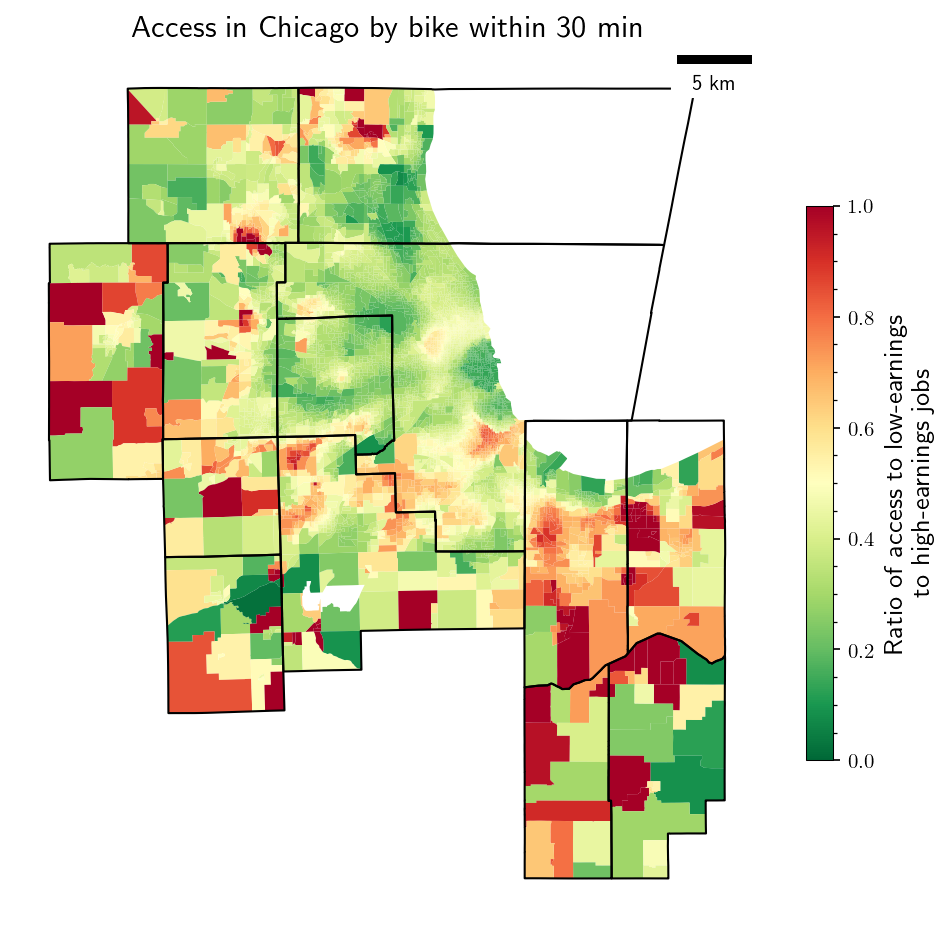

In [18]:
plot_access_map('msa', 'chicago', 'low2high', 'bike', '30', vmin=0, vmax=1)

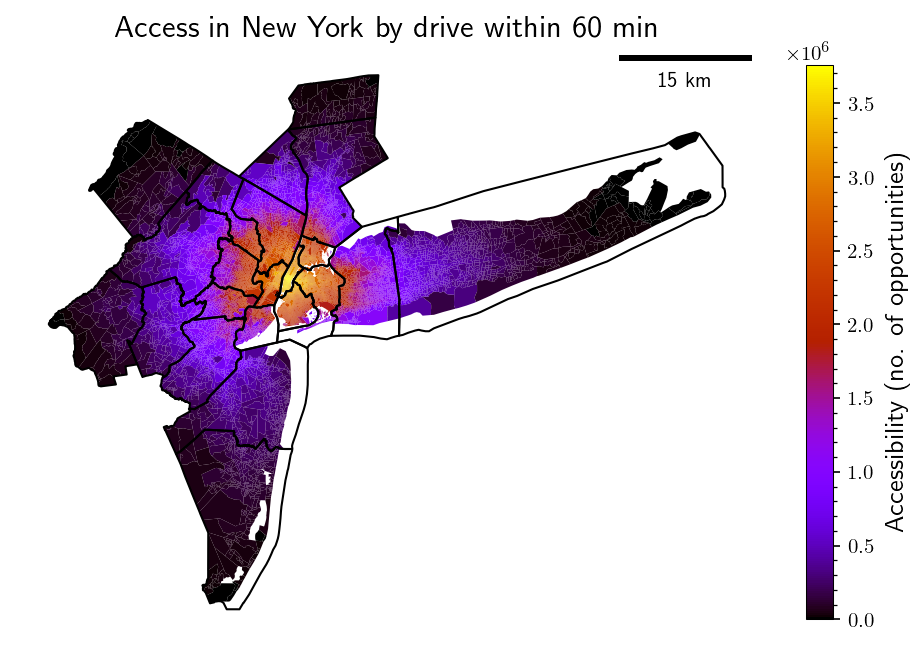

In [19]:
plot_access_map('msa', 'new-york', 'total', 'drive', '60')

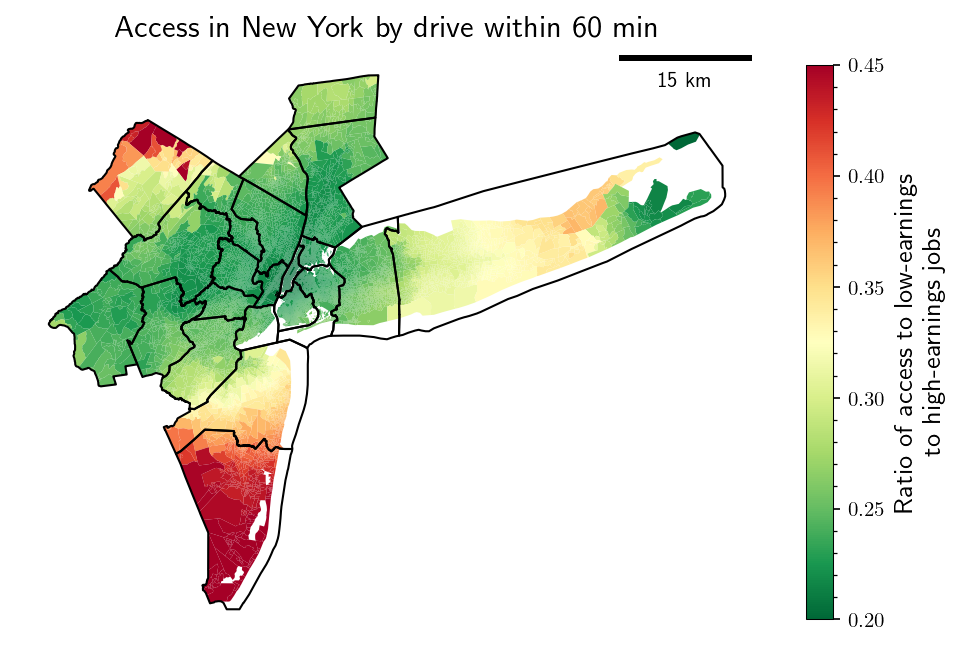

In [20]:
plot_access_map('msa', 'new-york', 'low2high', 'drive', '60', vmin=0.2, vmax=0.45)

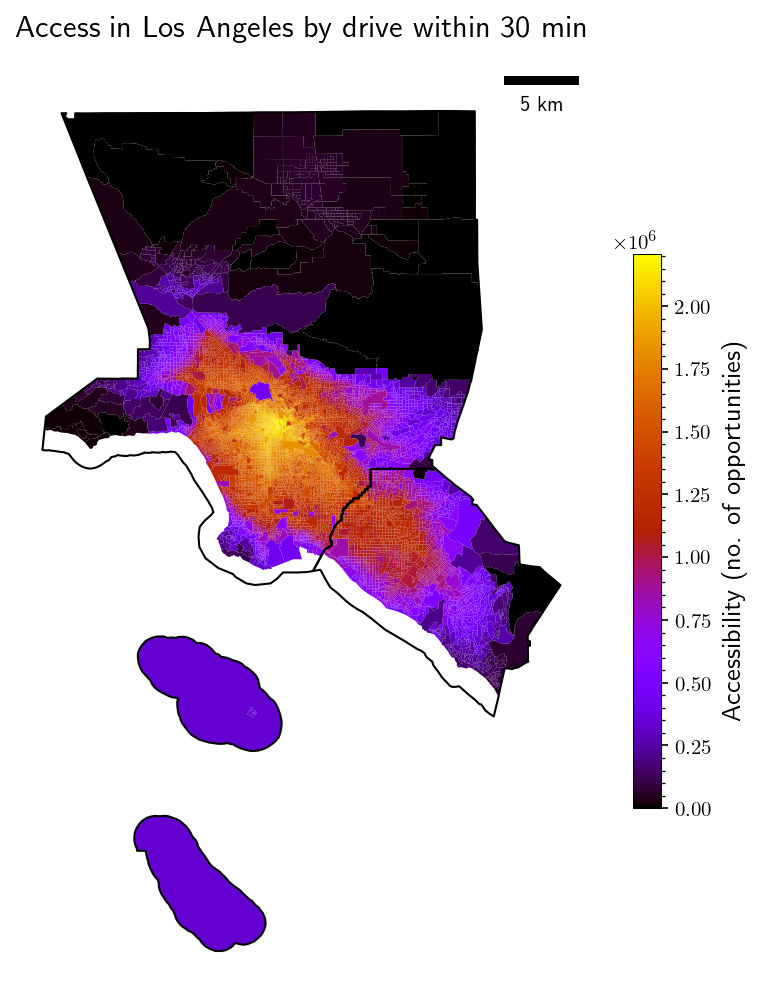

In [21]:
plot_access_map('msa', 'los-angeles', 'total', 'drive', '30')

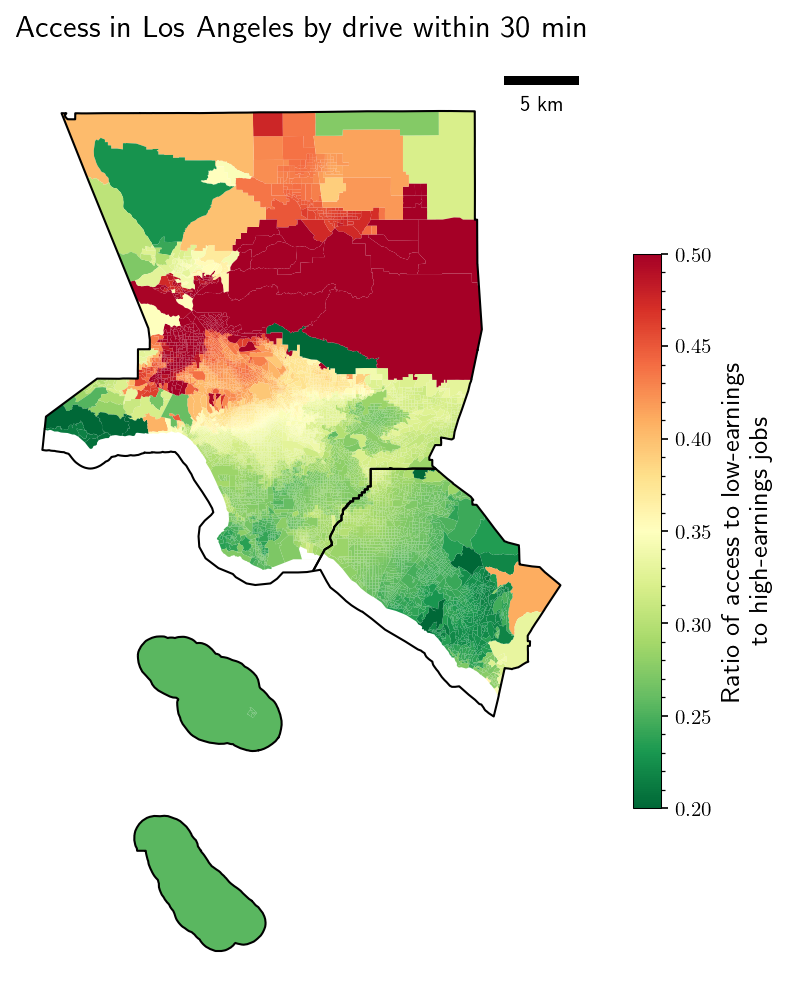

In [22]:
plot_access_map('msa', 'los-angeles', 'low2high', 'drive', '30', vmin=0.2, vmax=0.5)

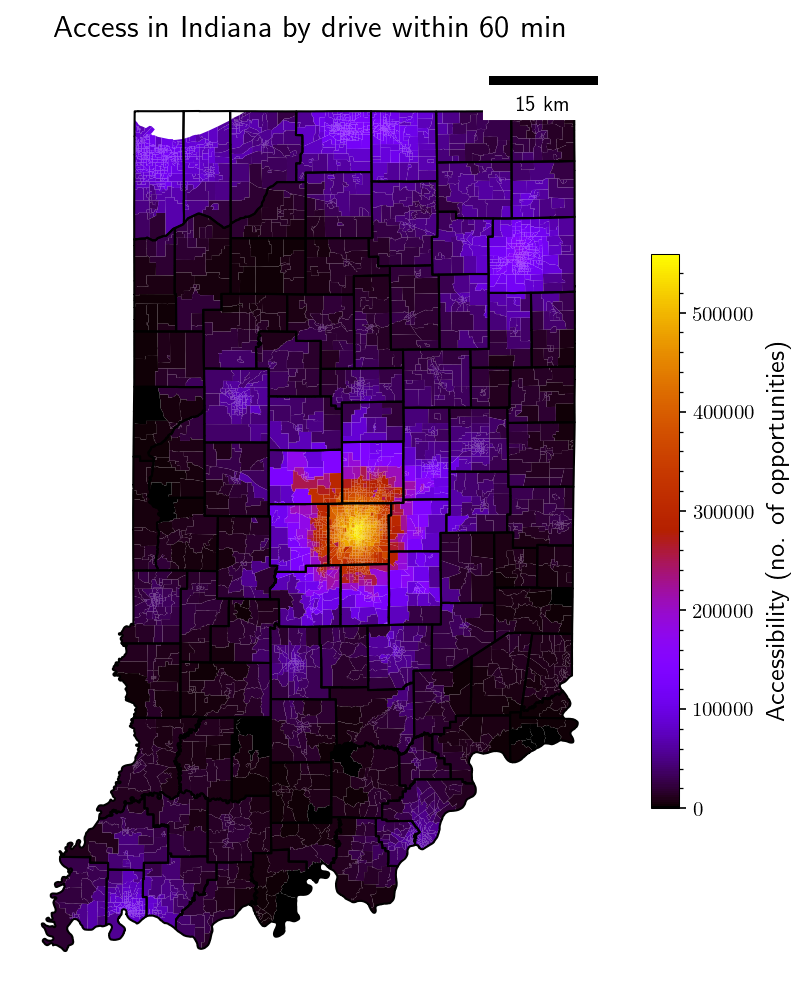

In [23]:
plot_access_map('state', 'indiana', 'total', 'drive', '60')

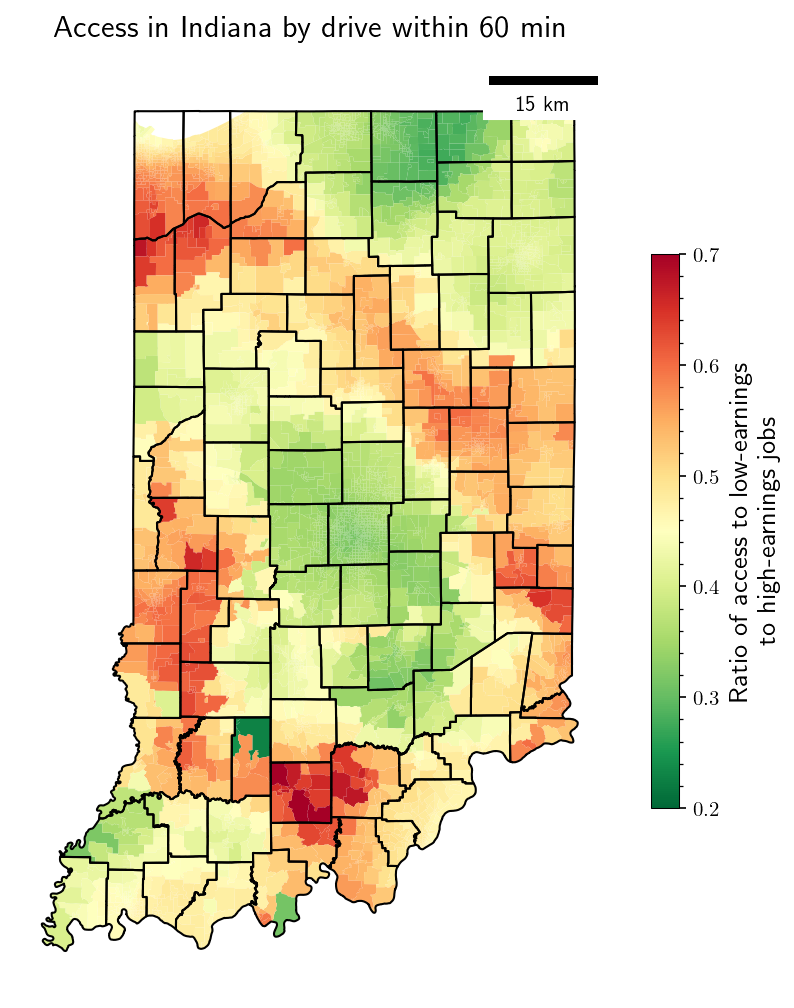

In [24]:
plot_access_map('state', 'indiana', 'low2high', 'drive', '60', vmin=0.2, vmax=0.7)

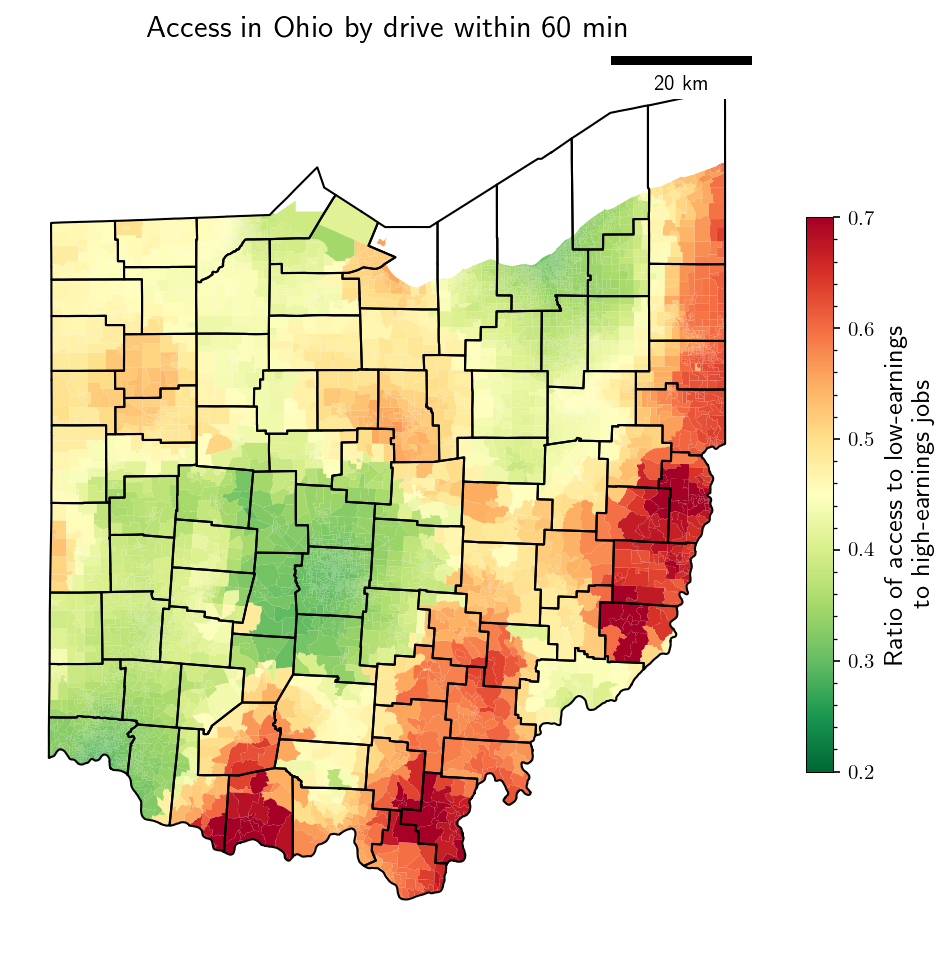

In [25]:
plot_access_map('state', 'ohio', 'low2high', 'drive', '60', vmin=0.2, vmax=0.7)

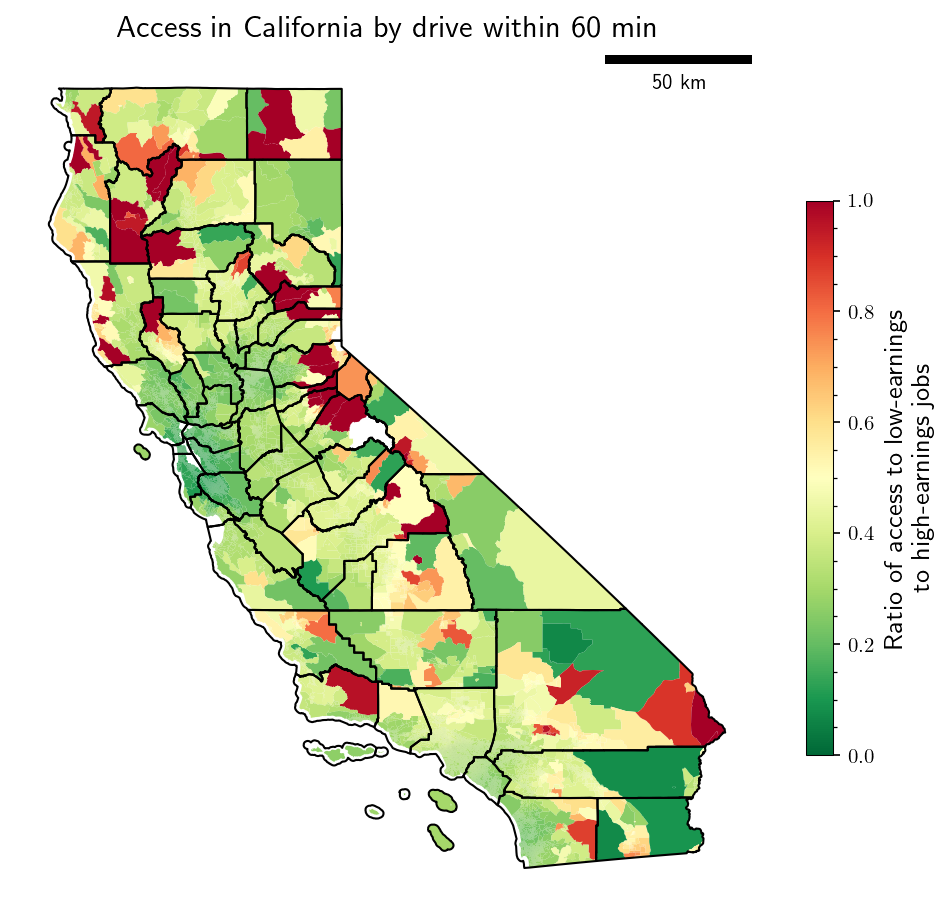

In [26]:
plot_access_map('state', 'california', 'low2high', 'drive', '60', vmin=0, vmax=1)